In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import sys
sys.path.append('./python_files/')
from model_trainer import ModelTrainer
from utils import *
from data_loader import load_data
from nn_modules import View


In [10]:
from sklearn.cross_decomposition import CCA

In [2]:
torch.__version__

'0.4.1'

In [3]:
train_input, train_target, test_input, test_target = load_data(cifar=False, normalize=True, flatten=False)
train_target = train_target.long()
test_target = test_target.long()

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


5


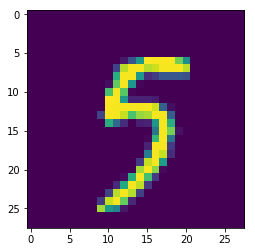

In [4]:
i = 420
plt.imshow(train_input[i, 0, :, :])
print(train_target[i].item())

## 1) LeNet with disjoint trainset and testset

In [31]:
train_dataset = (train_input, train_target)
test_dataset = (test_input, test_target)

in_channels = train_input.shape[1]
out_channels = 10

LeNet_gen = lambda : nn.Sequential(
        nn.Conv2d(in_channels, 6, kernel_size=(5, 5)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(6, 16, kernel_size=(5,5)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        View([-1]),

        nn.Linear(256, 120),
        nn.ReLU(),
        nn.Dropout(),

        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Dropout(),

        nn.Linear(84, out_channels),
        nn.Sigmoid()
    )

In [32]:
#debug_layers_dims(LeNet_gen(), train_input.shape)

In [33]:
target_classes = np.array(train_target.tolist())
unique, counts = np.unique(target_classes, return_counts=True)

print(dict(zip(unique, counts)))
crossEntropyClassesWeigths = Tensor(counts/len(target_classes))

{0: 97, 1: 116, 2: 99, 3: 93, 4: 105, 5: 92, 6: 94, 7: 117, 8: 87, 9: 100}


******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                       0.00230           0.113         0.00229           0.221
10                      0.00190           0.505         0.00180           0.661
20                      0.00171           0.696         0.00166           0.744
30                      0.00164           0.805         0.00161           0.802
40                      0.00161           0.831         0.00157           0.851
50                      0.00157           0.874         0.00156           0.875
60                      0.00154           0.917         0.00154           0.897
70                      0.00153           0.931         0.00153           0.910
80                      0.00152           0.943         0.00153           0.914
90                      0.00151           0.959         0.00152           0.924
100                     0.00150         

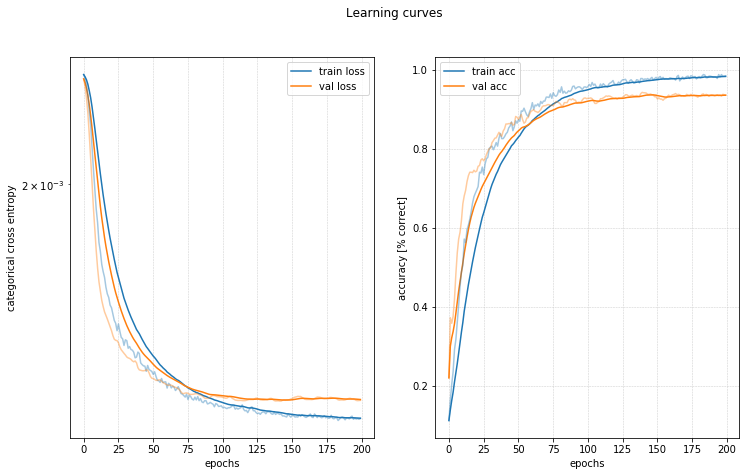

In [34]:
crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

LeNet = LeNet_gen()
loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.004

mt = ModelTrainer(LeNet, loss_fun, optim.Adam(LeNet.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(train_dataset, test_dataset, epochs=200, batch_size=None, verbose=10)
mt.plot_training("Learning curves")

In [234]:
LeNet.eval()
i = 36
print(LeNet(test_input[i].reshape(-1, 1, 28, 28)).argmax(1))
test_target[i]

tensor([2])


tensor(7)

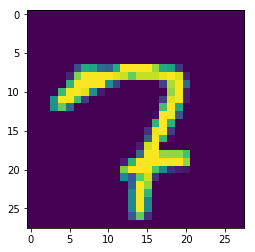

In [231]:
plt.imshow(test_input[36, 0])

In [125]:
activation_output = dict()
hook_layer_counter = 0

In [126]:
def my_hook(m, input_, output):
    print(str(m) + ' got ' + str(input_[0].size()))
    activation_output['Layer '+str(hook_layer_counter)+' : '+str(m)] = output
    hook_layer_counter += 1
    
def hook_reset(m, input_):
    print('\n===Reset the hook variables===\n')
    activation_output = dict()
    hook_layer_counter = 0

In [127]:
def add_forwark_hooks(model, hook_fun):
    handle_list = list()
    
    handle_list.append(model.register_forward_pre_hook(hook_reset))
    
    for m in model.modules():
         handle_list.append(m.register_forward_hook(hook_fun))
            
    return handle_list

def remove_hooks(handle_list):
    for h in handle_list:
         h.remove()

In [128]:
handles = add_forwark_hooks(LeNet, my_hook)

In [124]:
remove_hooks(handles)

In [97]:
LeNet.eval()
pass

In [129]:
LeNet(train_input[10:12].reshape(-1, 1, 28, 28))


===Reset the hook variables===

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1)) got torch.Size([2, 1, 28, 28])


UnboundLocalError: local variable 'hook_layer_counter' referenced before assignment

In [100]:
activation_output.get('Sigmoid()').shape

torch.Size([2, 10])

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(alexnet.parameters(), lr=0.001)

* Using CIFAR
Files already downloaded and verified
Files already downloaded and verified
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [10]:
target.reshape(-1, 1)

NameError: name 'target' is not defined

In [9]:
crit_fun = lambda input_, target : (input_, target.reshape(-1, 1))
y_hat_fun = lambda y: y.max(1)

mt = ModelTrainer(alexnet32, criterion, optimizer, y_hat_fun, crit_fun)
hist = mt.fit((train_input, train_target), (test_input, test_target), epochs=500, batch_size=250, verbose=10)
mt.plot_training("Learning curves")

RuntimeError: multi-target not supported at /Users/soumith/miniconda2/conda-bld/pytorch_1532623076075/work/aten/src/THNN/generic/ClassNLLCriterion.c:21